**Restaurant Review Classification**

- Mario Iskandar - 2502014841
- Darren Engelbert - 2502001763
- Lie Reubensto - 2540124633
- Reynaldi Joely - 2540124356

Dataset: https://www.kaggle.com/datasets/d4rklucif3r/restaurant-reviews

In [ ]:
# Tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
# Stopwords
from nltk.corpus import stopwords
# Frequency Distribution
from nltk.probability import FreqDist

from nltk.classify import NaiveBayesClassifier, accuracy
import pandas as pd
import string
import random
import pickle
import csv

In [ ]:
# MENU
def mainMenu():
    while True:
        print("1. Build Model")
        print("2. Show Model Evaluation")
        print("3. Test Review")
        print("4. Exit")
        try:
            choice = int(input(">> "))
            if(choice>=1 and choice<=4):
                return choice
            else:
                print("Input must be between [1-4]")
        except:
            print("Input must be int number")

In [ ]:
### CREATE/BUILD MODEL ###
def buildModel(df):
    # pisahin ke comment positif dan negatif
    pos=[]
    neg=[]

    for index, i in df.iterrows():
        if i['Liked']==1:
            pos.append(i['Review'])
        else:
            neg.append(i['Review'])

    # kalimat-kalimat dibagi dua berdasarkan positif dan negatif 

    # tokenizing + stop words + stemmings
    # TOKENIZE
    posTokenize=[]
    for i in pos:
        temp= word_tokenize(i)
        for j in temp:
            posTokenize.append(j)

    negTokenize=[]
    for i in neg:
        temp= word_tokenize(i)
        for j in temp:
            negTokenize.append(j)
    # positif -> 6021 kata
    # negatif -> 6663 kata

    # STOP WORDS
    eng_stopwords = stopwords.words('english')

    posStopWords=[word for word in posTokenize if word.lower() not in eng_stopwords]
    negStopWords=[word for word in negTokenize if word.lower() not in eng_stopwords]
    # positif -> 3596 kata
    # negatif -> 3786 kata


    posStopWordsPunctuations=[word for word in posStopWords if word not in string.punctuation]
    negStopWordsPunctuations=[word for word in negStopWords if word not in string.punctuation]
    # positif -> 2799 kata
    # negatif -> 3045 kata

    posIsAlpha=[word for word in posStopWords if word.isalpha()]
    negIsAlpha=[word for word in negStopWords if word.isalpha()]
    # positif -> 2660 kata
    # negatif -> 2793 kata

    # KUMPULAN SEMUA KATA2
    preprocessedWords=posIsAlpha + negIsAlpha
    # 5453 kata

    fd = FreqDist(preprocessedWords)
    preprocessedWords = [word for word, count in fd.most_common(1000)]

    ### BIKIN MODEL DENGAN NAIVE BAYES
    dataset=[]

    for index, data in df.iterrows():
        dict={}
        words = word_tokenize(data['Review'])
        for key in preprocessedWords:
            label='Negative'
            if(data['Liked']==1):
                label='Positive'
            value=key in words
            dict[key]=value
            dataset.append((dict,label))

    random.seed(42)
    random.shuffle(dataset)
    counter= int(len(dataset) *0.7)
    training_data = dataset[:counter]
    testing_data = dataset[counter:]

    classifier = NaiveBayesClassifier.train(training_data)

    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    for features, label in testing_data:
        predicted_label = classifier.classify(features)
        if predicted_label == 'Positive' and label == 'Positive':
            tp += 1
        elif predicted_label == 'Positive' and label == 'Negative':
            fp += 1
        elif predicted_label == 'Negative' and label == 'Positive':
            fn += 1

    pos_precision = tp / (tp + fp)
    pos_recall = tp / (tp + fn)

    print(f"TP={tp}, FP={fp}, FN={fn}")
    print('Precision (Positive):', pos_precision)
    print('Recall (Positive):', pos_recall)

    print("Accuracy:",accuracy(classifier,testing_data))

    # Save Model
    file = open("model.pickle","wb")
    pickle.dump(classifier,file)
    file.close()

    file = open("test.pickle","wb")
    pickle.dump(testing_data,file)
    file.close()

In [ ]:
### READ MODEL ###
def readModel():
    file = open("model.pickle","rb")
    classifier=pickle.load(file)
    file.close()
    return classifier

### Input Review ###
def reviewTest(classifier):
    # Result
    review =input("Input review here: ")
    words=word_tokenize(review)
    result = classifier.classify(FreqDist(words)) # argumentnya freqdist
    print(result)
    print("")

### Show Accuracy ###
def showAccuracy():
    file = open("test.pickle","rb")
    testing_data=pickle.load(file)
    file.close()
    classifier=readModel()
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    for features, label in testing_data:
        predicted_label = classifier.classify(features)
        if predicted_label == 'Positive' and label == 'Positive':
            tp += 1
        elif predicted_label == 'Positive' and label == 'Negative':
            fp += 1
        elif predicted_label == 'Negative' and label == 'Positive':
            fn += 1

    pos_precision = tp / (tp + fp)
    pos_recall = tp / (tp + fn)

    print(f"TP={tp}, FP={fp}, FN={fn}")
    print('Precision (Positive):', pos_precision)
    print('Recall (Positive):', pos_recall)
    print("Accuracy:",accuracy(classifier,testing_data))

In [ ]:
### MENU UTAMA ###
menu=0
df = pd.read_csv('Restaurant_Reviews.tsv',sep='\t').dropna()

while True:
    menu = mainMenu()
    if(menu==1):
        print("Building Model and Evaluation...")
        buildModel(df)
    elif(menu==2):
        print("Model Evaluation")
        showAccuracy()
    elif (menu==3):
        print("3. Test review")
        classifier=readModel()
        reviewTest(classifier)
    elif (menu==4):
        print("Goodbye...")
        break

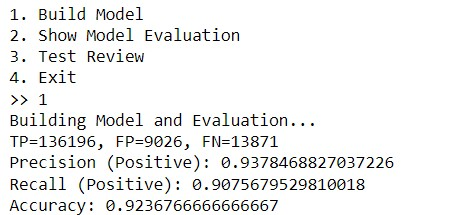

most_common = 1000